# Overview

We have 4 members in our team, so this project is to classify the handwritting between the 4 members.

To remove the huge boilerplate code, we have structured our code into a python package (we pushed to GitHub) that can be imported into this notebook.

We constructed the dataset and implement a custom PyTorch dataset loader.

We modified various model architectures' including:
- Vision Transformer
- Resnet (Resnet50, Resnet101, Resnet 152)

and import it to this project to solve members' handwriting classification problems.

# Import the datasets and models

Make sure to cd into the directory.

In [1]:
!git clone -q https://github.com/chiew256/sc-group-assignment.git
%cd /content/sc-group-assignment
!git checkout main

/content/sc-group-assignment
Branch 'main' set up to track remote branch 'main' from 'origin'.
Switched to a new branch 'main'


# Import libraries

We used PyTorch to train our neural network. We setupped gpu devices to accelerate progress.

In [2]:
!pip install -q shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.4 MB/s eta 0:00:00


In [3]:
import random # random
import numpy as np # arithmatics
import matplotlib.pyplot as plt # plotting lib

import torch # pytorch
from torch import nn, optim # pytorch core module
from torch.utils.data import DataLoader # pytorch dataset loader

import shap # explainer

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

# Ensure the result reproducibility

In [4]:
seed = 42

random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Construct & Split Pytorch Dataset

You can find how we build the Dataset Module in dataset.py. We implemented custom stratified split function to split the members and characters equally. So, each train and test set have equally members' characters.

In [5]:
from dataset import HandwritingDataset, PrepForDataLoader

dataset = HandwritingDataset()
train_dataset, test_dataset = dataset.stratified_split()
train_dataset, test_dataset = PrepForDataLoader(train_dataset), PrepForDataLoader(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, worker_init_fn=seed_worker, generator=g,)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, worker_init_fn=seed_worker, generator=g,)

Who are the members? ['yeow', 'oeh', 'chua', 'chiew']

Member yeow  contributed 230 characters including classes: ['2', '4', '1', '6', '7', '8', '3', '9', '5', '0']
Member oeh   contributed 230 characters including classes: ['2', '4', '1', '6', '7', '8', '3', '9', '5', '0']
Member chua  contributed 230 characters including classes: ['2', '4', '1', '6', '7', '8', '3', '9', '5', '0']
Member chiew contributed 230 characters including classes: ['2', '4', '1', '6', '7', '8', '3', '9', '5', '0']

Constructed members' handwriting dataset for 4 members with total 920 characters

Train dataset with stratified split: 600
Test dataset with stratified split: 280



Each of the member contribute 230 characters with only digits from 0 - 9.

# Analyze Dataset

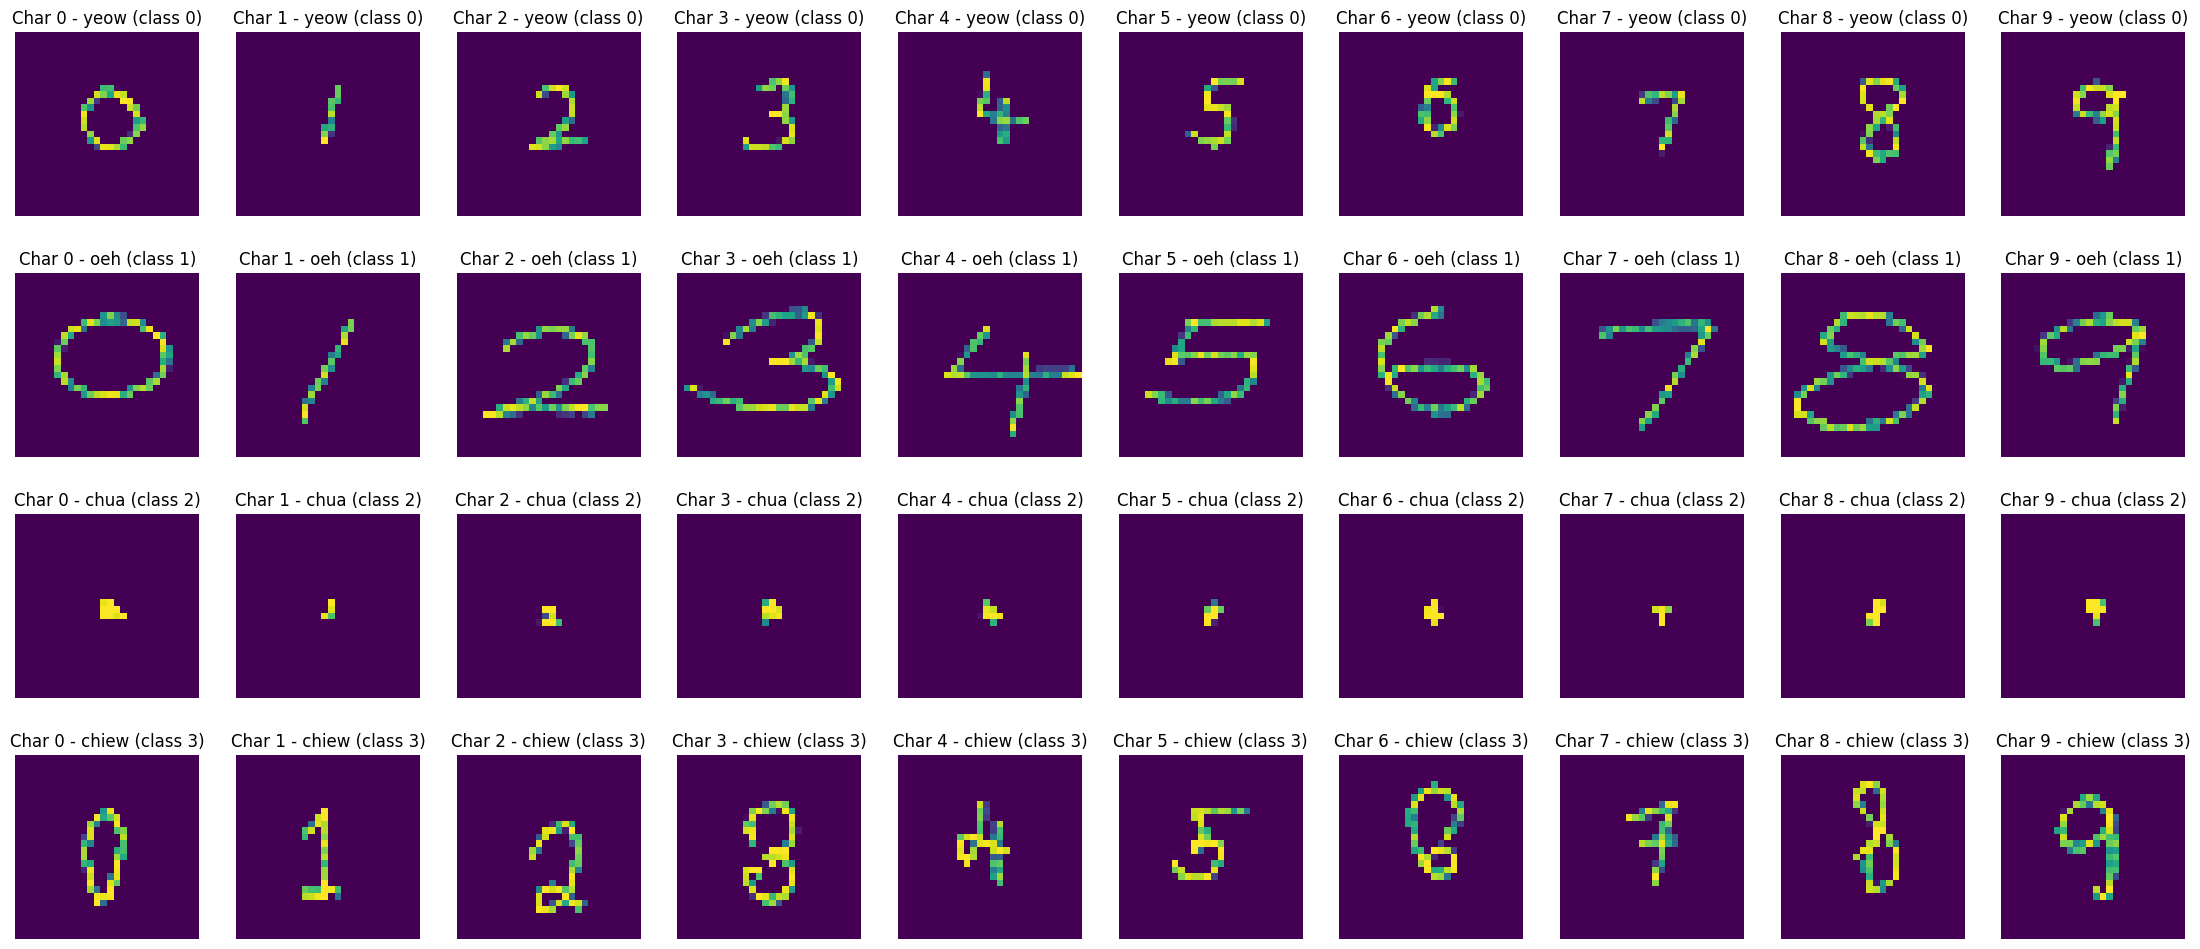

In [ ]:
np.random.seed(seed)
randint = np.random.randint(0, 13)

cls = dataset.get_cls()
chars = dataset.get_chars()

def plot(char, x, y, subplot=None):
    if subplot: plt.subplot(*subplot)
    plt.title(f'Char {char} - {dataset.get_class_label(y)} (class {y})')
    plt.axis('off')
    plt.imshow(x)

plt.figure(figsize=(28, 12))
for i, (cls_idx, _cls) in enumerate(cls.items()):
    for j, char in enumerate(chars):
        index = dataset.get(cls_idx, char)[randint]
        ch, (x, y) = dataset[index]
        plot(ch, x.permute(1, 2, 0), y, (len(cls), len(chars), i * len(chars) + j + 1))

# Prepare Trainer (Training Loop)

We've also build a Trainer module, to **handle training loop** including model forward, backward propagation, gradient updates with custom optimizer and to **reduce the boilerplate code**. See trainer.py for more details.

In [6]:
from trainer import Trainer

# trainer = Trainer(config)
# trainer.train() -> train the model
# trainer.plot() -> plot the model metrics

# Build the model

## Custom Vision Transformer

Transformers have been originally proposed to process sets since it is a permutation-equivariant architecture, i.e., producing the same output permuted if the input is permuted. To apply Transformers to sequences, we have simply added a positional encoding to the input feature vectors, and the model learned by itself what to do with it. So, why not do the same thing on images? This is exactly what [Alexey Dosovitskiy et al.](https://openreview.net/pdf?id=YicbFdNTTy) proposed.

We use the Pre-Layer Normalization version of the Transformer blocks proposed by [Ruibin Xiong et al.](http://proceedings.mlr.press/v119/xiong20b/xiong20b.pdf)  in 2020. The idea is to apply Layer Normalization not in between residual blocks, but instead as a first layer in the residual blocks. This reorganization of the layers supports better gradient flow and removes the necessity of a warm-up stage.

Note: you can see the implementation under [sc-group-assignment/models/vit.py](https://github.com/chiew256/sc-group-assignment/blob/main/models/vit.py)

### Architecture (Vision Transformer)

In [7]:
from models.vit import VIT

vit_config = {
    "num_classes": 4,
    "num_channels": 1,
    "embed_dim": 768,
    "hidden_dim": 512,
    "num_heads": 8,
    "num_layers": 6,
    "patch_size": 4,
    "num_patches": 64,
    "dropout": 0.2,
}

vit = VIT(vit_config)
vit

VisionTransformer(
  (input_layer): Linear(in_features=16, out_features=768, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (layer_norm_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=768, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=512, out_features=768, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (layer_norm_2): Layer

### Training (Vision Transformer)

In [8]:
lr = 3e-4
epochs = 100
n_evals = 5

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)

In [ ]:
vit_trainer = Trainer(
    {
        "model": vit,
        "model_type": 'vit',
        "criterion": criterion,
        "optimizer": optimizer,
        "scheduler": scheduler,
        "train_loader": train_loader,
        "test_loader": test_loader,
        "epochs": epochs,
        "n_evals": n_evals,
        "device": device,
    }
)

vit_trainer.train()

Epoch:   1 | train loss: 1.069296 | train accuracy: 0.565000 | test loss: 0.957620 | test accuracy: 0.575000 | time: 1.653374
Epoch:   5 | train loss: 0.223078 | train accuracy: 0.931667 | test loss: 0.308113 | test accuracy: 0.925000 | time: 1.665272
Epoch:  10 | train loss: 0.215694 | train accuracy: 0.941667 | test loss: 0.307236 | test accuracy: 0.910714 | time: 1.710936
Epoch:  15 | train loss: 0.227351 | train accuracy: 0.936667 | test loss: 0.307004 | test accuracy: 0.907143 | time: 1.721366
Epoch:  20 | train loss: 0.220988 | train accuracy: 0.933333 | test loss: 0.300436 | test accuracy: 0.892857 | time: 1.695524
Epoch:  25 | train loss: 0.224406 | train accuracy: 0.936667 | test loss: 0.300446 | test accuracy: 0.907143 | time: 1.667833
Epoch:  30 | train loss: 0.220962 | train accuracy: 0.931667 | test loss: 0.312543 | test accuracy: 0.910714 | time: 1.643960
Epoch:  35 | train loss: 0.226627 | train accuracy: 0.933333 | test loss: 0.315028 | test accuracy: 0.896429 | time: 1

### Evaluation (Vision Transformer)

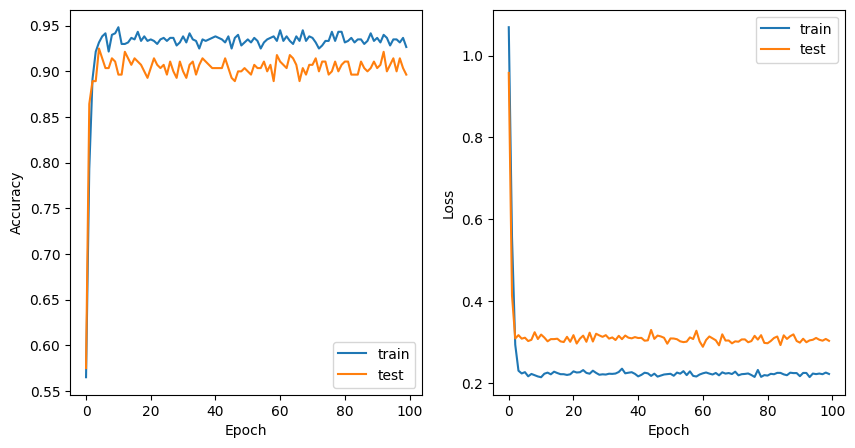

In [ ]:
# This cell only works in colab or specific machine type

import matplotlib; matplotlib.use('module://matplotlib_inline.backend_inline')
vit_trainer.plot()

In [ ]:
vit_trainer.evaluate()

----------Training Set----------
Loss: 0.21406129002571106
Accuracy: 0.935

----------Testing Set----------
Loss: 0.30600684881210327
Accuracy: 0.9035714285714286


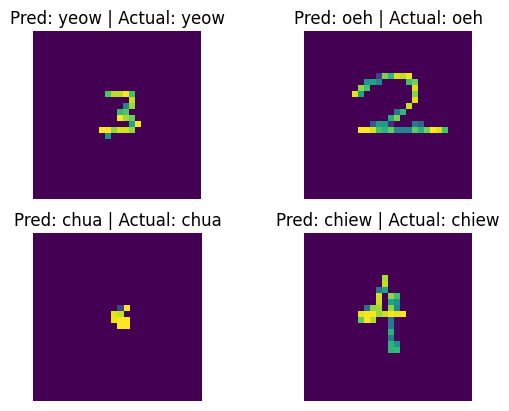

In [ ]:
indices = [46, 190, 400, 513]

vit.eval().cpu()

for i, id in enumerate(indices):
  plt.subplot(2, 2, i + 1)
  x, y = train_dataset[id]
  pred = vit(x.unsqueeze(0)).argmax()
  plt.imshow(x.permute(1, 2, 0))
  plt.title(f'Pred: {dataset.get_class_label(pred)} | Actual: {dataset.get_class_label(y)}')
  plt.axis('off')

plt.show()

## Custom Resnet

A Residual Neural Network (a.k.a. Residual Network, ResNet) is a deep learning model in which the weight layers learn residual functions with reference to the layer inputs. A Residual Network is a network with skip connections that perform identity mappings, merged with the layer outputs by addition. It behaves like a Highway Network whose gates are opened through strongly positive bias weights. This enables deep learning models with tens or hundreds of layers to train easily and approach better accuracy when going deeper.

### Architecture (Resnet50)

In [10]:
from models.resnet import ResNet50

resnet50_config = {
    "num_classes": 4,
    "num_channels": 1,
}
resnet50 = ResNet50(resnet50_config)
resnet50

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (i_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, m

### Training (ResNet50)

In [11]:
lr = 3e-4
epochs = 100
n_evals = 5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=lr)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-4)
# scheduler = None

In [ ]:
resnet50_trainer = Trainer(
    {
        "model": resnet50,
        "model_type": 'resnet50',
        "criterion": criterion,
        "optimizer": optimizer,
        "scheduler": scheduler,
        "train_loader": train_loader,
        "test_loader": test_loader,
        "epochs": epochs,
        "n_evals": n_evals,
        "device": device,
    }
)

resnet50_trainer.train()

Epoch:   1 | train loss: 1.147199 | train accuracy: 0.546667 | test loss: 0.860512 | test accuracy: 0.689286 | time: 0.922936
Epoch:   5 | train loss: 0.117054 | train accuracy: 0.953333 | test loss: 0.608909 | test accuracy: 0.800000 | time: 0.835339
Epoch:  10 | train loss: 0.212154 | train accuracy: 0.946667 | test loss: 1.022480 | test accuracy: 0.782143 | time: 0.957229
Epoch:  15 | train loss: 0.011291 | train accuracy: 0.996667 | test loss: 0.921546 | test accuracy: 0.810714 | time: 0.861605
Epoch:  20 | train loss: 0.038665 | train accuracy: 0.988333 | test loss: 0.748842 | test accuracy: 0.839286 | time: 0.845353
Epoch:  25 | train loss: 0.019816 | train accuracy: 0.991667 | test loss: 0.795150 | test accuracy: 0.835714 | time: 0.915647
Epoch:  30 | train loss: 0.027913 | train accuracy: 0.986667 | test loss: 1.116227 | test accuracy: 0.817857 | time: 0.871215
Epoch:  35 | train loss: 0.010581 | train accuracy: 0.998333 | test loss: 0.931121 | test accuracy: 0.835714 | time: 0

### Evaluation (ResNet50)

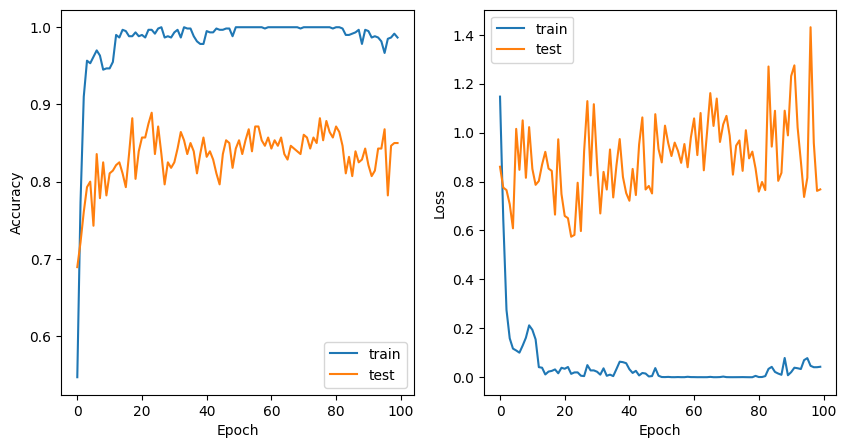

In [ ]:
# This cell only works in colab or specific machine type

import matplotlib; matplotlib.use('module://matplotlib_inline.backend_inline')
resnet50_trainer.plot()

In [ ]:
resnet50_trainer.evaluate()

----------Training Set----------
Loss: 0.0016791957896202803
Accuracy: 1.0

----------Testing Set----------
Loss: 0.7842041254043579
Accuracy: 0.8535714285714285


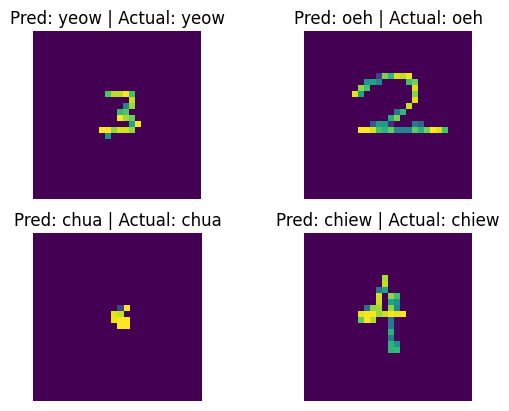

In [ ]:
indices = [46, 190, 400, 513]

resnet50.eval().cpu()

for i, id in enumerate(indices):
  plt.subplot(2, 2, i + 1)
  x, y = train_dataset[id]
  pred = resnet50(x.unsqueeze(0)).argmax()
  plt.imshow(x.permute(1, 2, 0))
  plt.title(f'Pred: {dataset.get_class_label(pred)} | Actual: {dataset.get_class_label(y)}')
  plt.axis('off')

plt.show()

# Analyze Model

See the impact of pixel features in shap for vision transformer and resnet50.

Blue colour: In SHAP, blue is typically used to represent features that have a negative impact or contribute negatively towards a prediction. A blue-coloured bar or plot indicates that the feature is pushing the model prediction towards a lower value or decreasing the likelihood of a certain outcome.

Red colour: Conversely, red is used to represent features that have a positive impact or contribute positively towards a prediction. A red-coloured bar or plot indicates that the feature is pushing the model prediction towards a higher value or increasing the likelihood of a certain outcome.

The intensity or shade of blue or red in the visualisations provided by SHAP can vary, depending on the magnitude of the feature's impact. Darker shades usually indicate a stronger influence, while lighter shades imply a relatively milder effect.

## Vision Transformer

### Shap DeepExplainer

In [ ]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch

background = images[:100]
test_images = images[100:]

e = shap.DeepExplainer(vit.to(device), background.to(device))
shap_values = e.shap_values(test_images.to(device))

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

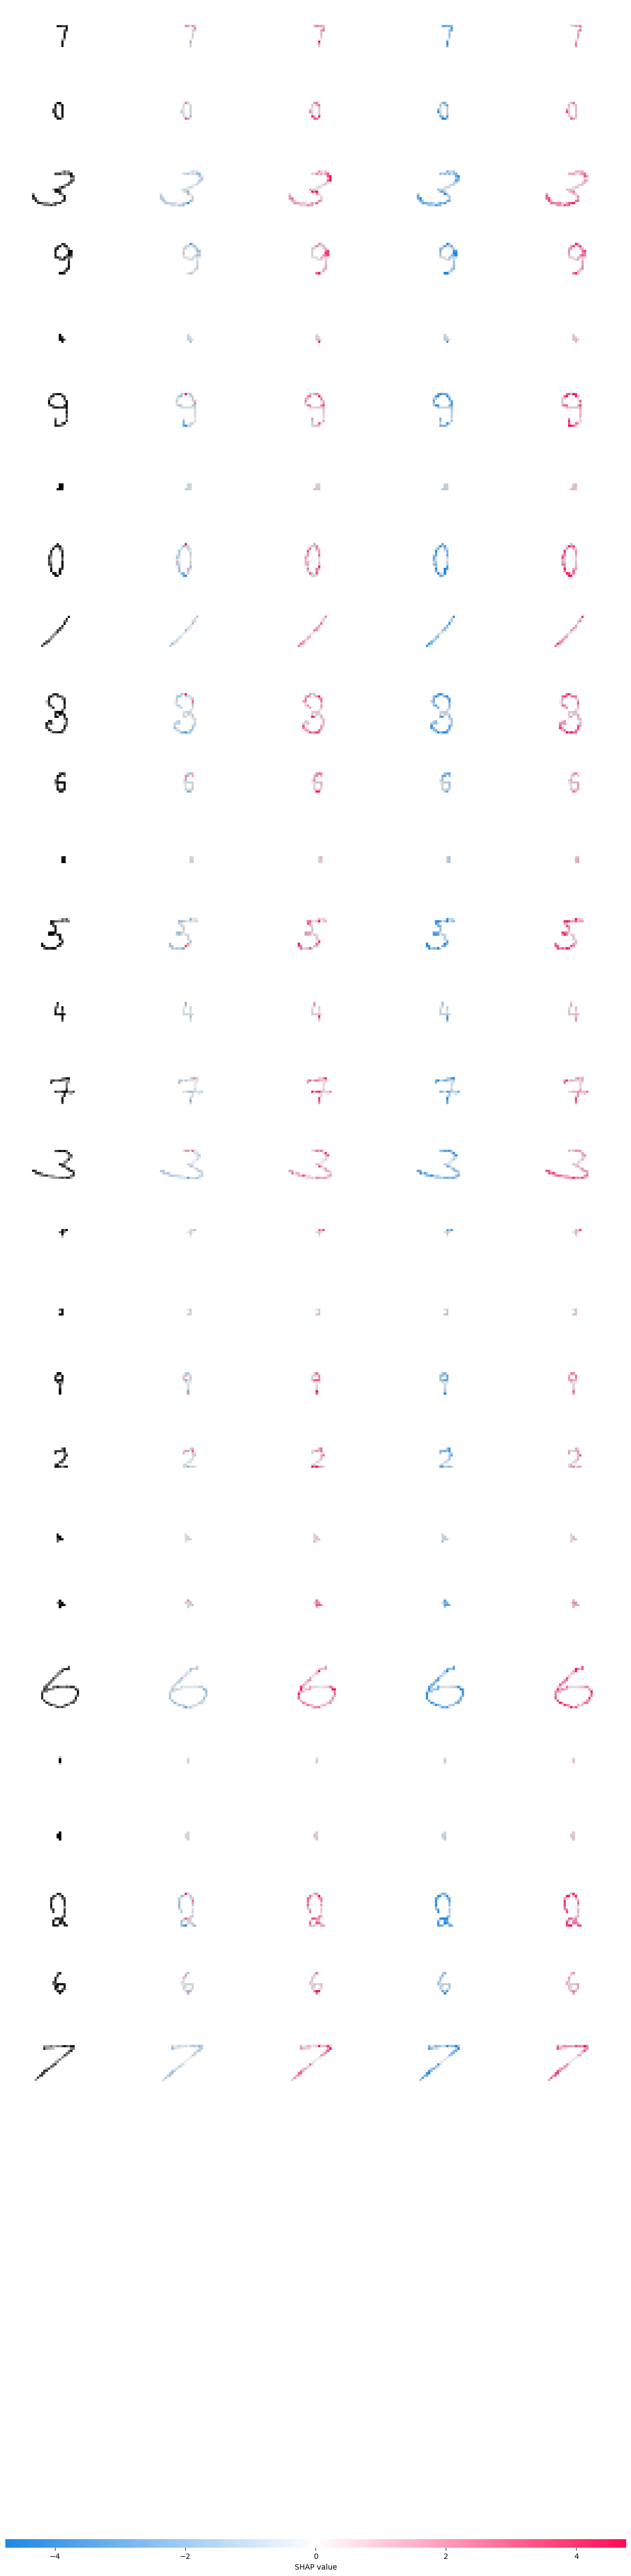

In [ ]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)

### Shap Gradient Explainer

Explain the last multi headed linear layers. See the gradient of the last head layer.

In [14]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, labels = batch

background = images[:100].to(device)
test_images = images[100:].to(device)
vit.to(device)

e = shap.GradientExplainer((vit, vit.mlp_head[1]), background)
shap_values,indexes = e.shap_values(test_images, ranked_outputs=2, nsamples=200)

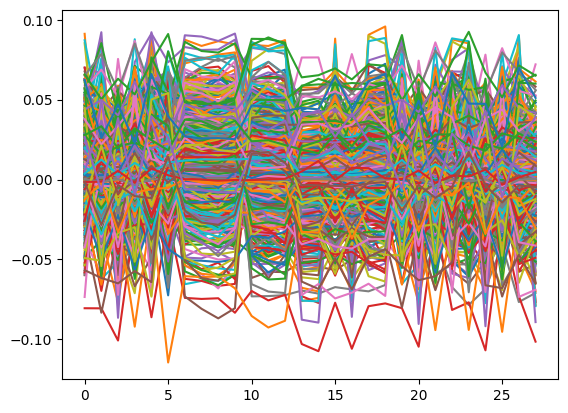

In [23]:
# This cell only works in colab or specific machine type

import matplotlib; matplotlib.use('module://matplotlib_inline.backend_inline')
plt.plot(np.array(shap_values)[0])
plt.plot(np.array(shap_values)[1])
plt.show()

## ResNet50

### Shap DeepExplainer

In [ ]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch

background = images[:100]
test_images = images[100:]

e = shap.DeepExplainer(vit.to(device), background.to(device))
shap_values = e.shap_values(test_images.to(device))

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

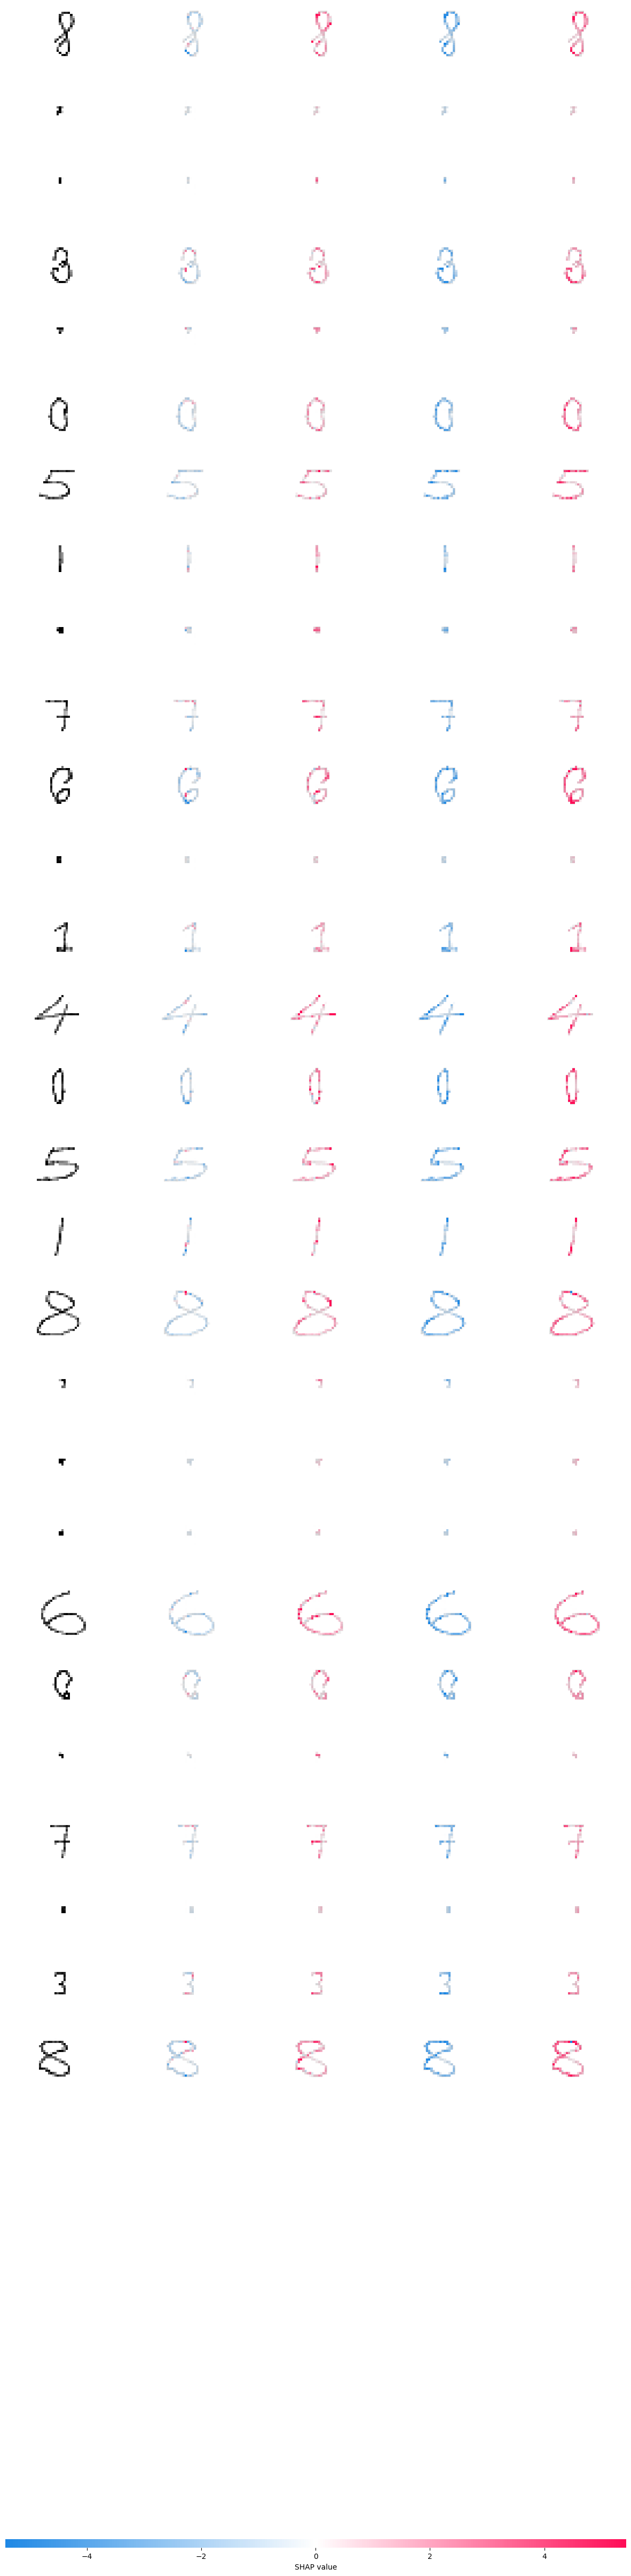

In [ ]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)

### Shap Gradient Explainer

Explain the last multi headed linear layers. See the gradient of the last head layer.

In [25]:
resnet50.conv1

Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [28]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, labels = batch

background = images[:100].to(device)
test_images = images[100:].to(device)
vit.to(device)

e = shap.GradientExplainer((resnet50, resnet50.conv1), background)
shap_values, indexes = e.shap_values(test_images, ranked_outputs=2, nsamples=200)

In [56]:
shap_val = np.array([np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values])
index_names = np.array([dataset.get_cls()[x.item()] for x in labels])

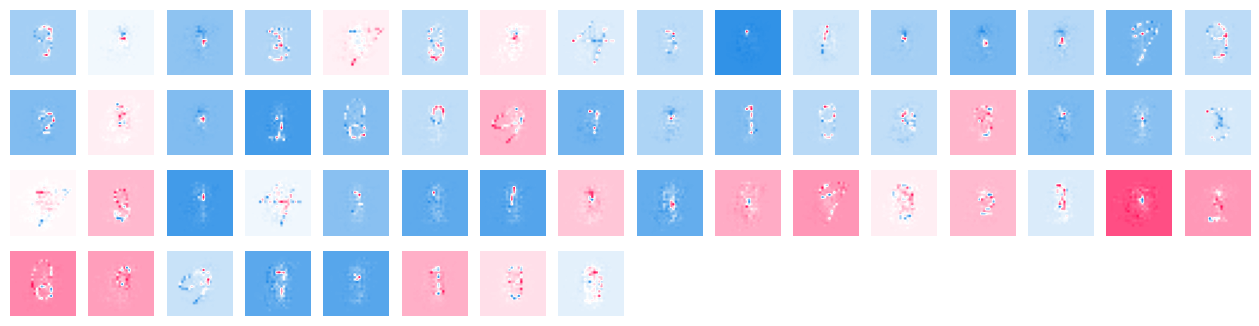

In [94]:
from matplotlib.colors import LinearSegmentedColormap

colors = []
for l in np.linspace(1, 0, 100):
    colors.append((30./255, 136./255, 229./255,l))
for l in np.linspace(0, 1, 100):
    colors.append((255./255, 13./255, 87./255,l))
red_transparent_blue = LinearSegmentedColormap.from_list("red_transparent_blue", colors)

plt.figure(figsize=(16, 4))
for i in range(2):
  for j in range(28):
    plt.subplot(4, 16, (j + 28 * i) + 1)
    plt.imshow(shap_val[i][j], cmap=red_transparent_blue)
    plt.axis('off')
plt.show()